# OD Matrix of local authorities

In [32]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

## Processing the OD Matrix

In [2]:
od_matrix = pd.read_csv('data/2131100155226451_data.tsv', sep='\t')

In [3]:
areas_geom = gpd.read_file('data/CMLAD.gpkg')
code_ref = pd.read_csv('data/2131100155226451_geog.tsv', sep='\t')

In [4]:
areas_geom

,cmlad11cd,cmlad11nm,cmlad11nmw,GlobalID,geometry
0,E41000001,Hartlepool,,{3870FB87-B05C-4897-BBD7-809677956DFD},"MULTIPOLYGON (((447851.199 537035.999, 447096...."
1,E41000002,Middlesbrough,,{471D524C-582F-4287-8FF1-6904ABCE708C},"MULTIPOLYGON (((450790.999 520932.499, 448483...."
2,E41000003,Redcar and Cleveland,,{BABB72CB-01DC-4663-8DCE-05853A5D01CC},"MULTIPOLYGON (((456987.199 526324.899, 455684...."
3,E41000004,Stockton-on-Tees,,{A82819CD-2459-412F-B301-FBE00CAE3AC5},"MULTIPOLYGON (((445399.999 526934.300, 444828...."
4,E41000005,Darlington,,{1C15A2EA-271F-4C33-B4F1-746DE28375AD},"MULTIPOLYGON (((423240.200 524970.900, 422247...."
...,...,...,...,...,...
341,W40000018,Torfaen,Tor-faen,{1D819A78-4B04-48CA-B7E9-09F103FCA8AE},"MULTIPOLYGON (((329240.001 202667.400, 328687...."
342,W40000019,Monmouthshire,Sir Fynwy,{672460AE-9ADF-451C-954B-72FCEB76DCC5},"MULTIPOLYGON (((326793.200 232168.999, 326033...."
343,W40000020,Newport,Casnewydd,{09B30D9E-9BD9-4D4A-86C6-CC179822B8D2},"MULTIPOLYGON (((342769.301 194118.500, 342194...."
344,W40000021,Powys,Powys,{A53F5E23-DC7C-4AC3-8E89-9DCA0DCE93FE},"MULTIPOLYGON (((322417.099 334026.401, 321104...."


In [5]:
code_ref

,geogcode,description
0,E41000001,Hartlepool
1,E41000002,Middlesbrough
2,E41000003,Redcar and Cleveland
3,E41000004,Stockton-on-Tees
4,E41000005,Darlington
...,...,...
399,95PP,Fermanagh
400,95UU,Moyle
401,95WW,Newtownabbey
402,95KK,Cookstown


In [6]:
od_matrix['geogcode'].unique().shape

(404,)

In [7]:
# areas_geom['TTWA11CD'].unique()

In [8]:
od_matrix.head(5)

,Population,Units,Date,Method of travel to wor,geogcode,place of work,value type,value,flag
0,All usual residents aged 16 and over in employ...,Persons,2011,All categories: Method of travel to work (2001...,E41000001,{place of work}Hartlepool,number,20777,NaN
1,All usual residents aged 16 and over in employ...,Persons,2011,All categories: Method of travel to work (2001...,E41000001,{place of work}Middlesbrough,number,1591,NaN
2,All usual residents aged 16 and over in employ...,Persons,2011,All categories: Method of travel to work (2001...,E41000001,{place of work}Redcar and Cleveland,number,534,NaN
3,All usual residents aged 16 and over in employ...,Persons,2011,All categories: Method of travel to work (2001...,E41000001,{place of work}Stockton-on-Tees,number,3865,NaN
4,All usual residents aged 16 and over in employ...,Persons,2011,All categories: Method of travel to work (2001...,E41000001,{place of work}Darlington,number,433,NaN


In [9]:
od_matrix_pivot = od_matrix.pivot_table(index=['geogcode', 'place of work'], columns='Method of travel to wor', values='value', fill_value=0)

In [10]:
od_matrix_pivot.reset_index(inplace=True)

In [11]:
od_matrix_pivot['place of work'] = od_matrix_pivot['place of work'].str.replace('{place of work}', '')

In [12]:
# merge with code_ref to get the destination name
od_matrix_pivot_edit = od_matrix_pivot.merge(code_ref, left_on='geogcode', right_on='geogcode', how='left')
od_matrix_pivot_edit.rename(columns={'description': 'origin_name', 'geogcode': 'origin_code'}, inplace=True)
od_matrix_pivot_edit = od_matrix_pivot_edit.merge(code_ref, left_on='place of work', right_on='description', how='left').drop(columns = 'description').rename(columns={'place of work': 'destination_name', 'geogcode': 'destination_code'})


In [13]:
# reorder columns
od_matrix_pivot_edit = od_matrix_pivot_edit[['origin_code', 'origin_name', 'destination_code', 'destination_name'] + list(od_matrix_pivot_edit.columns[2:-2])].copy()

In [14]:
od_matrix_pivot_edit.rename(columns = {'All categories: Method of travel to work (2001 specification)': 'Total'}, inplace=True)

In [15]:
od_matrix_pivot_edit['public transport'] = od_matrix_pivot_edit[['Bus, minibus or coach', 'Train', 'Underground, metro, light rail or tram']].sum(axis=1)
od_matrix_pivot_edit['private vehicle'] = od_matrix_pivot_edit[['Driving a car or van', 'Motorcycle, scooter or moped', 'Passenger in a car or van']].sum(axis=1)
od_matrix_pivot_edit['active travel'] = od_matrix_pivot_edit[['Bicycle', 'On foot']].sum(axis=1)

In [16]:
od_matrix_pivot_edit['pt_share'] = (od_matrix_pivot_edit['public transport'] / (od_matrix_pivot_edit['Total'])).fillna(0)
od_matrix_pivot_edit['private_share'] = (od_matrix_pivot_edit['private vehicle'] / (od_matrix_pivot_edit['Total'])).fillna(0)

In [17]:
od_matrix_pivot_edit

,origin_code,origin_name,destination_code,destination_name,Total,Bicycle,"Bus, minibus or coach",Driving a car or van,"Motorcycle, scooter or moped",On foot,...,Passenger in a car or van,Taxi,Train,"Underground, metro, light rail or tram",Work mainly at or from home,public transport,private vehicle,active travel,pt_share,private_share
0,95AA,Antrim,S12000033,Aberdeen City,2.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.5
1,95AA,Antrim,S12000034,Aberdeenshire,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
2,95AA,Antrim,E41000244,Adur,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,95AA,Antrim,E41000065,Allerdale,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
4,95AA,Antrim,E41000071,Amber Valley,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163211,W40000022,Merthyr Tydfil,E41000255,Wychavon,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163212,W40000022,Merthyr Tydfil,E41000059,Wycombe,3.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
163213,W40000022,Merthyr Tydfil,E41000160,Wyre,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163214,W40000022,Merthyr Tydfil,E41000256,Wyre Forest,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [18]:
# save the edited od matrix to a new CSV file
od_matrix_pivot_edit.to_csv('data/od_matrix_pivot.csv', index=False)

### Extract data for the major cities within our area

In [19]:
cities_list = ['Liverpool', 'Manchester', 'Sheffield', 'Leeds', 'York', 'Doncaster', 'Kingston upon Hull, City of', 'Kirklees', 'Bradford', 'Wakefield', 'Barnsley', 'Rotherham', 'Stockport', 'Westminster,City of London', 'Birmingham']

In [20]:
od_matrix_pivot_edit[od_matrix_pivot_edit['origin_name'].isin(cities_list) & od_matrix_pivot_edit['destination_name'].isin(cities_list)].to_csv('data/od_matrix_extracted.csv', index=False)

<Axes: xlabel='Total', ylabel='pt_share'>

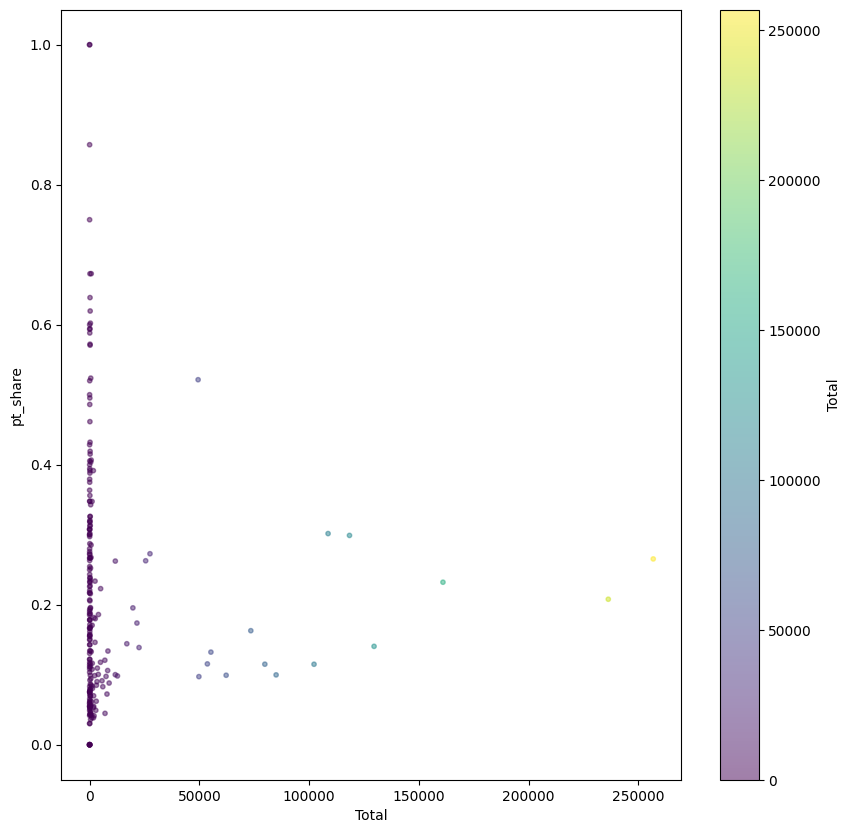

In [21]:
od_matrix_pivot_edit[od_matrix_pivot_edit['origin_name'].isin(cities_list) & od_matrix_pivot_edit['destination_name'].isin(cities_list)].plot.scatter(
    x='Total', y='pt_share', c='Total', 
    colormap='viridis', alpha=0.5, s=10, figsize=(10, 10)
)

### Get distances



In [22]:
from shapely.geometry import Point

# Merge areas_geom with od_matrix_pivot_edit for origin and destination
od_matrix_with_geom = od_matrix_pivot_edit.merge(
    areas_geom[['cmlad11cd', 'geometry']],
    left_on='origin_code',
    right_on='cmlad11cd',
    how='left'
).rename(columns={'geometry': 'origin_geometry'})

od_matrix_with_geom = od_matrix_with_geom.merge(
    areas_geom[['cmlad11cd', 'geometry']],
    left_on='destination_code',
    right_on='cmlad11cd',
    how='left'
).rename(columns={'geometry': 'destination_geometry'})

# Drop the duplicate cmlad11cd columns
od_matrix_with_geom = od_matrix_with_geom.drop(columns=['cmlad11cd_x', 'cmlad11cd_y'])

# Calculate the distance between origin and destination
od_matrix_with_geom['distance'] = od_matrix_with_geom.apply(
    lambda row: row['origin_geometry'].distance(row['destination_geometry'])
    if row['origin_geometry'] is not None and row['destination_geometry'] is not None else None,
    axis=1
)

# Convert distance to kilometers (assuming CRS is in meters)
od_matrix_with_geom['distance_km'] = od_matrix_with_geom['distance'] / 1000

# Display the updated DataFrame
od_matrix_with_geom[['origin_code', 'destination_code', 'distance_km']].head()

,origin_code,destination_code,distance_km
0,95AA,S12000033,NaN
1,95AA,S12000034,NaN
2,95AA,E41000244,NaN
3,95AA,E41000065,NaN
4,95AA,E41000071,NaN


## Visualisation of the OD matrix



In [23]:
# get the cities code
codes = [
    'E41000324', # London (Westminster + City of London)
    'E41000281', # Birmingham
    'E41000259', # Manchester
    'E41000268', # Liverpool
    'E41000291', # Leeds
    'E41000275', # Sheffield
    'E41000010', # Kingston upon Hull
    'E41000273', # Doncaster
]

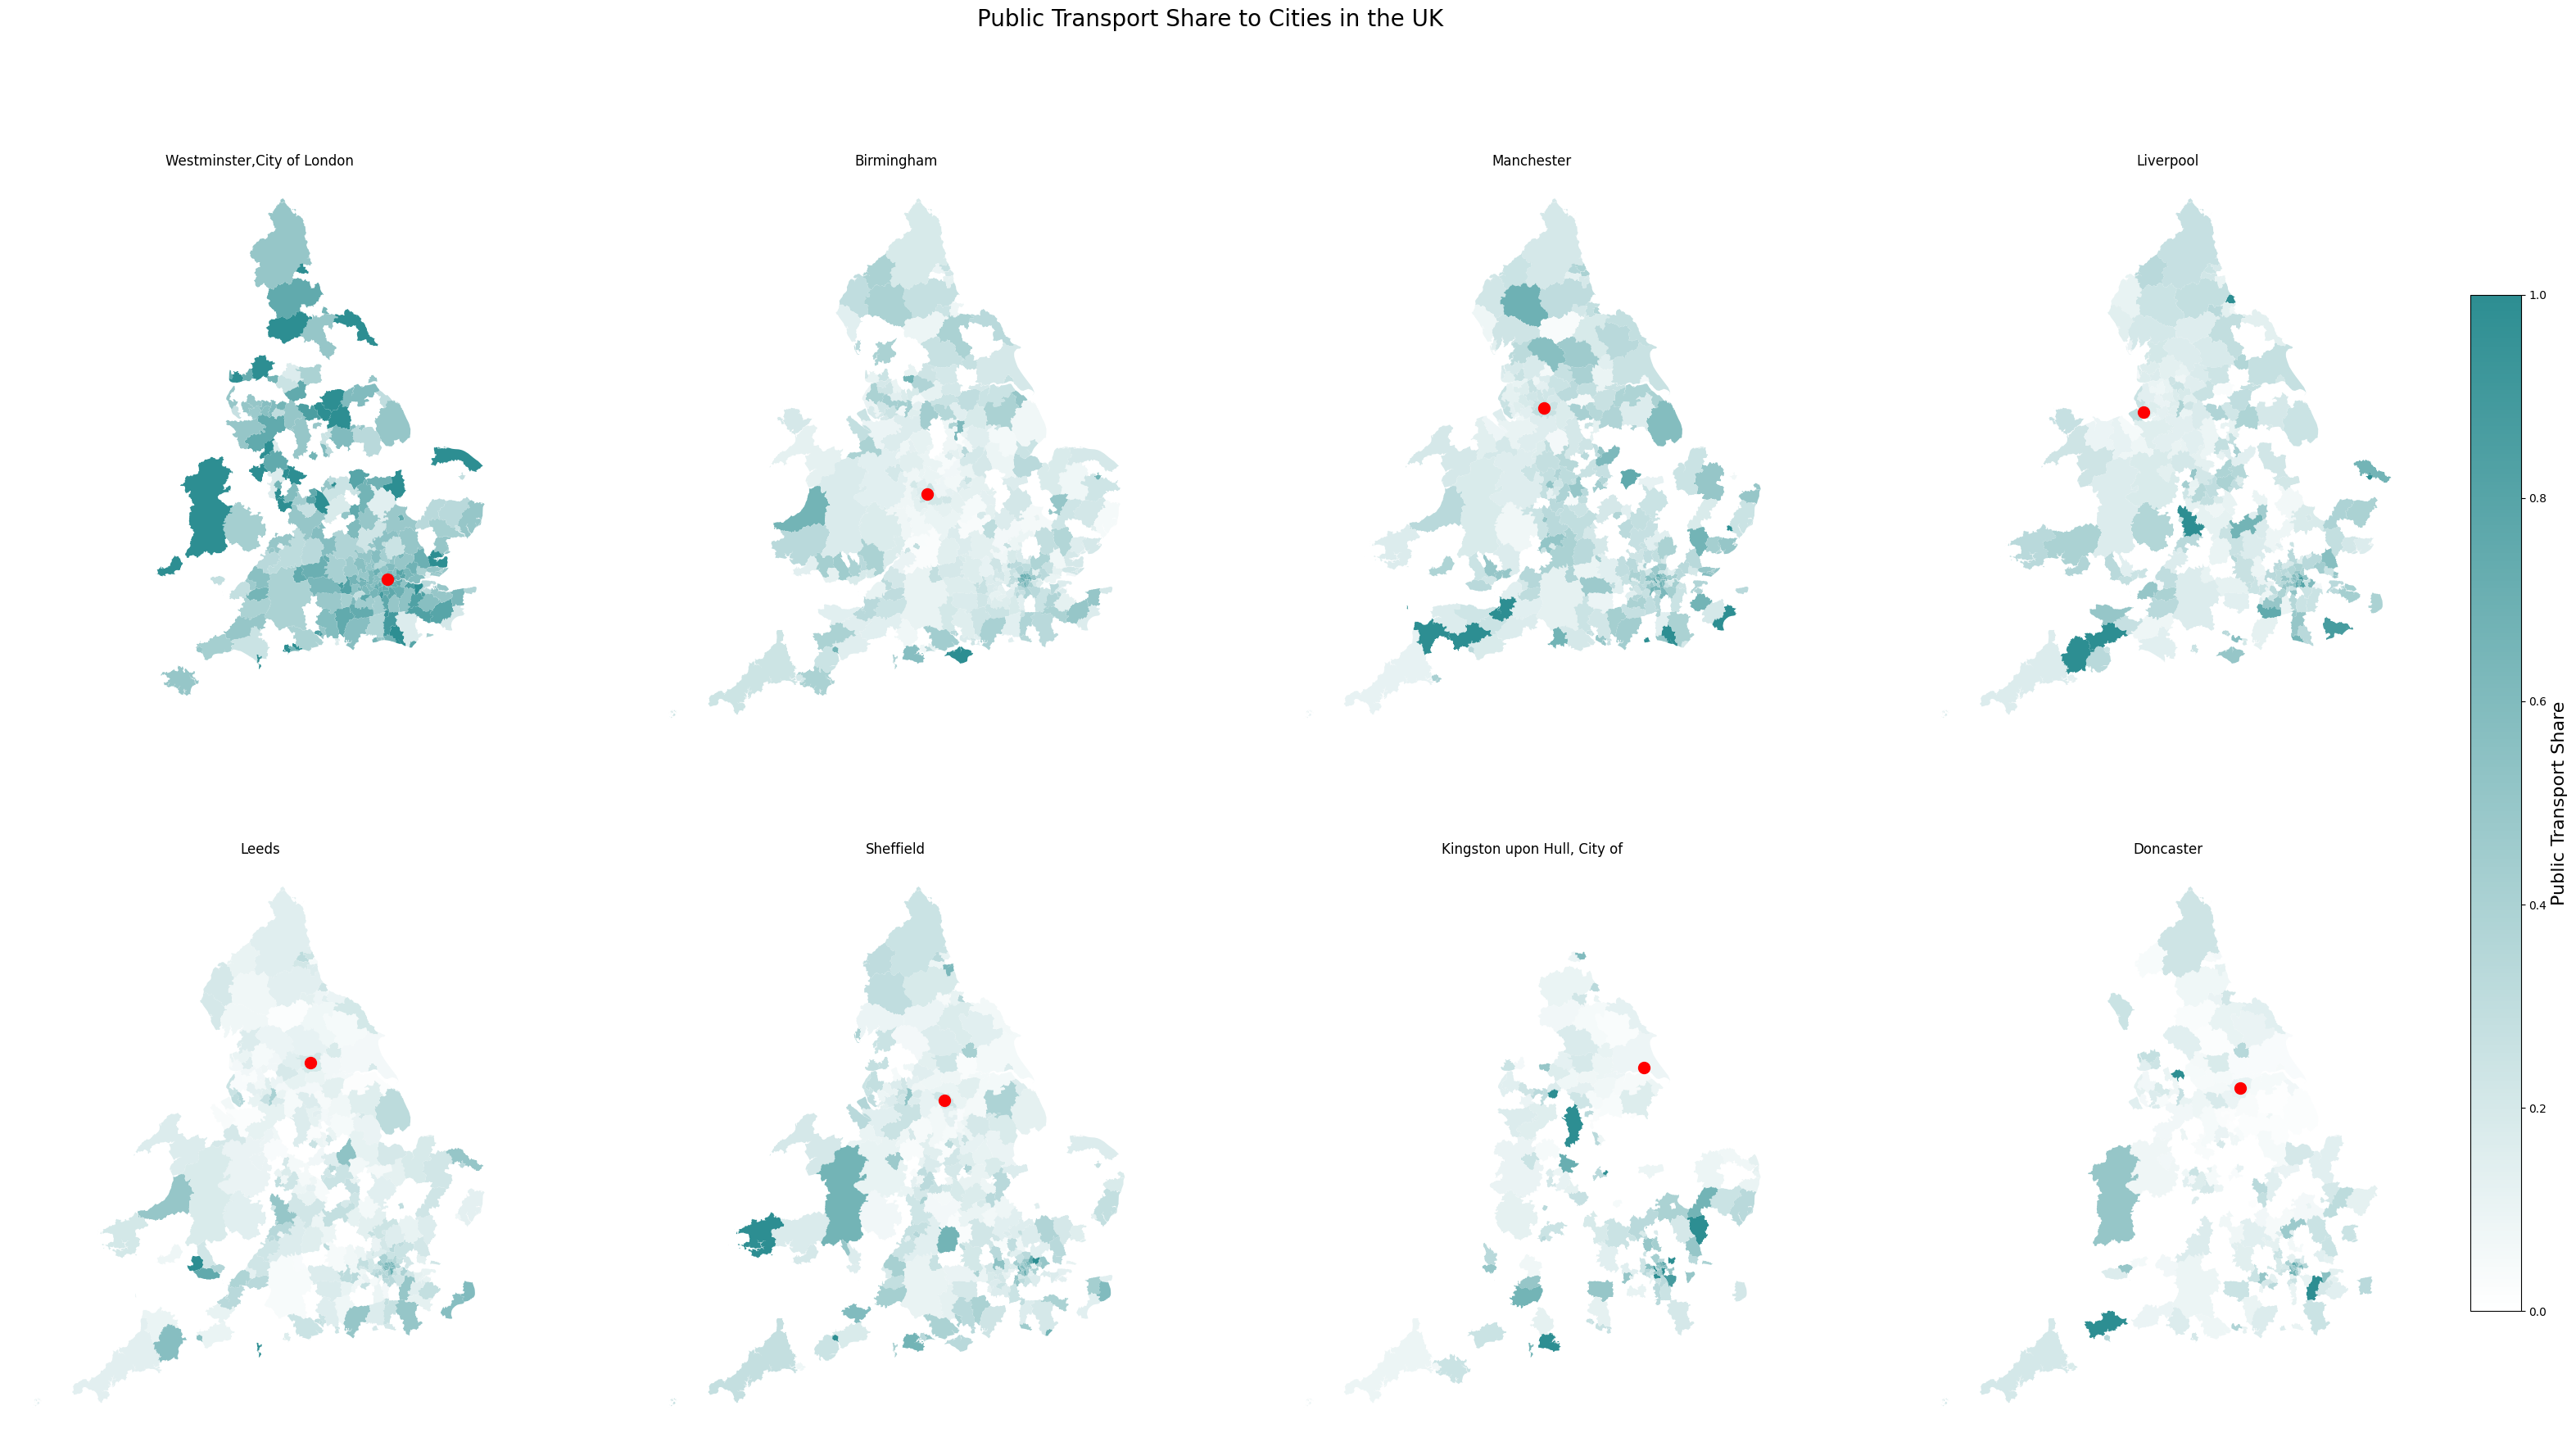

In [24]:
from matplotlib.colors import LinearSegmentedColormap
# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(40, 20))  # 4x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration
# Define a custom colormap from white to #184851

custom_cmap = LinearSegmentedColormap.from_list('custom_blues', ['white', '#2d8e92'])
cmap = custom_cmap
# Define a colormap and normalization for consistent color scaling
norm = mpl.colors.Normalize(vmin=0, vmax=1)


# Loop through the codes and create a plot for each city
for c in codes:
    ax=axes[codes.index(c)]
    # Filter the DataFrame for the current code
    df_temp = od_matrix_pivot_edit[od_matrix_pivot_edit['origin_code'] == c]

    # merge with geometry
    df_temp = areas_geom.merge(df_temp, left_on='cmlad11cd', right_on='destination_code', how='left')

    name = areas_geom[areas_geom['cmlad11cd'] == c]['cmlad11nm'].values[0]

    # Plotting
    df_temp.plot(ax=ax, column = 'pt_share', cmap=cmap, norm=norm)
    areas_geom[areas_geom['cmlad11cd'] == c].centroid.plot(ax=ax, marker='o', color='red', markersize=100)
    ax.set_axis_off()
    ax.set_title(name)

# Add a single colorbar for the entire figure
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label("Public Transport Share", fontsize=16)

plt.suptitle('Public Transport Share to Cities in the UK', fontsize=20)
plt.savefig('map/od_matrix_pivot.svg', dpi=300, format = 'svg', bbox_inches='tight')

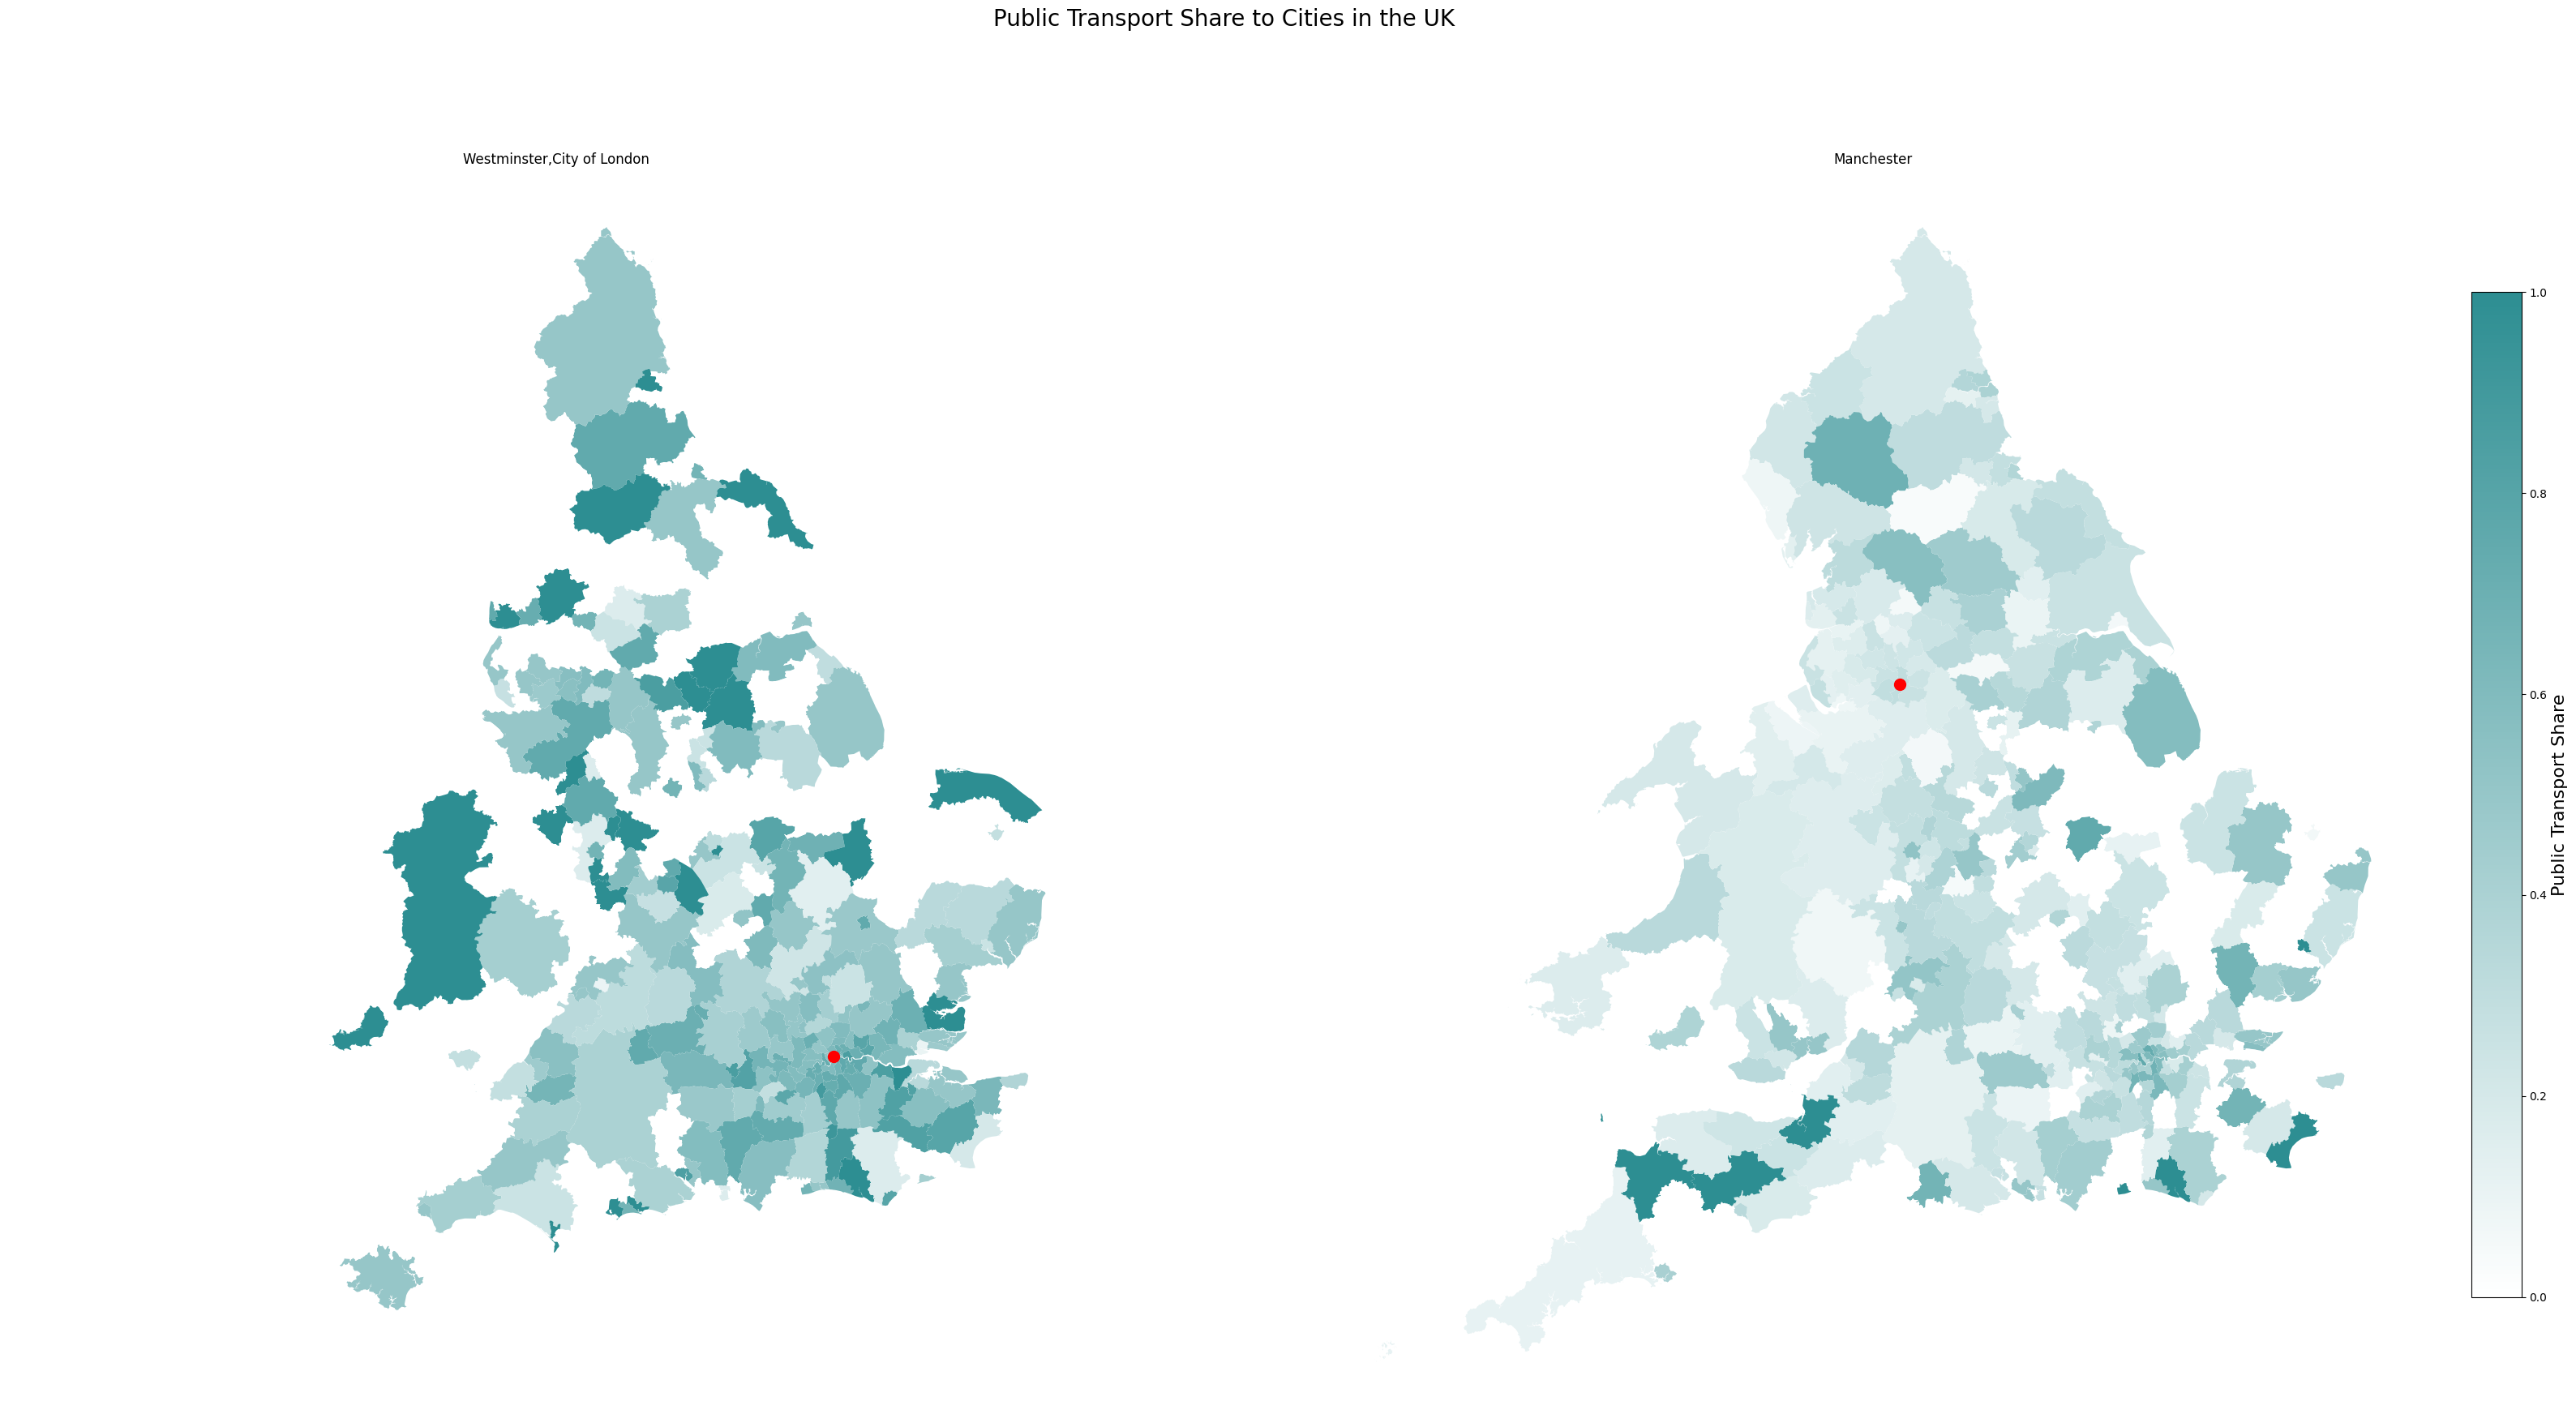

In [38]:
from matplotlib.colors import LinearSegmentedColormap
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(40, 20))  # 4x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easier iteration
# Define a custom colormap from white to #184851

custom_cmap = LinearSegmentedColormap.from_list('custom_blues', ['white', '#2d8e92'])
cmap = custom_cmap
# Define a colormap and normalization for consistent color scaling
norm = mpl.colors.Normalize(vmin=0, vmax=1)


# Loop through the codes and create a plot for each city
for c in ['E41000324', 'E41000259']:
    ax=axes[['E41000324', 'E41000259'].index(c)]
    # Filter the DataFrame for the current code
    df_temp = od_matrix_pivot_edit[od_matrix_pivot_edit['origin_code'] == c]

    # merge with geometry
    df_temp = areas_geom.merge(df_temp, left_on='cmlad11cd', right_on='destination_code', how='left')

    name = areas_geom[areas_geom['cmlad11cd'] == c]['cmlad11nm'].values[0]

    # Plotting
    df_temp.plot(ax=ax, column='pt_share', cmap=cmap, norm=norm, missing_kwds={"color": "gray"})
    areas_geom[areas_geom['cmlad11cd'] == c].centroid.plot(ax=ax, marker='o', color='red', markersize=100)
    ax.set_axis_off()
    ax.set_title(name)

# Add a single colorbar for the entire figure
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label("Public Transport Share", fontsize=16)

plt.suptitle('Public Transport Share to Cities in the UK', fontsize=20)
plt.savefig('map/od_matrix_pivot_LONMAN.svg', dpi=300, format = 'svg', bbox_inches='tight')

In [25]:
od_matrix_pivot_edit[od_matrix_pivot_edit['origin_code'] == 'E41000259']

,origin_code,origin_name,destination_code,destination_name,Total,Bicycle,"Bus, minibus or coach",Driving a car or van,"Motorcycle, scooter or moped",On foot,...,Passenger in a car or van,Taxi,Train,"Underground, metro, light rail or tram",Work mainly at or from home,public transport,private vehicle,active travel,pt_share,private_share
114736,E41000259,Manchester,S12000033,Aberdeen City,19.0,2.0,2.0,5.0,0.0,1.0,...,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.210526,0.263158
114737,E41000259,Manchester,S12000034,Aberdeenshire,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,0.000000
114738,E41000259,Manchester,E41000244,Adur,2.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,1.000000
114739,E41000259,Manchester,E41000065,Allerdale,9.0,0.0,2.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,7.0,0.0,0.222222,0.777778
114740,E41000259,Manchester,E41000071,Amber Valley,17.0,0.0,1.0,6.0,0.0,4.0,...,2.0,1.0,3.0,0.0,0.0,4.0,8.0,4.0,0.235294,0.470588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115135,E41000259,Manchester,E41000255,Wychavon,6.0,0.0,2.0,2.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.333333,0.666667
115136,E41000259,Manchester,E41000059,Wycombe,10.0,0.0,3.0,7.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,7.0,0.0,0.300000,0.700000
115137,E41000259,Manchester,E41000160,Wyre,51.0,0.0,6.0,21.0,0.0,9.0,...,10.0,0.0,4.0,0.0,0.0,10.0,31.0,9.0,0.196078,0.607843
115138,E41000259,Manchester,E41000256,Wyre Forest,3.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.000000,0.666667


In [26]:
areas_geom[areas_geom['cmlad11nm'].str.contains('Liverpool')]

,cmlad11cd,cmlad11nm,cmlad11nmw,GlobalID,geometry
267,E41000268,Liverpool,,{053EC91D-98C9-4760-8F70-5EDB564C6951},"MULTIPOLYGON (((338864.100 397980.099, 336621...."


In [27]:
# calculated the share of public transport
od_share = od_matrix_pivot_edit.groupby('destination_name').agg({'Total': 'sum', 'public transport': 'sum', 'private vehicle': 'sum'}).reset_index()

od_share['pt_share'] = od_share['public transport'] / od_share['Total']
od_share['private_share'] = od_share['private vehicle'] / od_share['Total']

In [28]:
od_share

,destination_name,Total,public transport,private vehicle,pt_share,private_share
0,Aberdeen City,140815.0,21733.0,93132.0,0.154337,0.661378
1,Aberdeenshire,70873.0,3584.0,55275.0,0.050569,0.779916
2,Adur,16327.0,1534.0,11728.0,0.093955,0.718319
3,Allerdale,31973.0,1469.0,24321.0,0.045945,0.760673
4,Amber Valley,45311.0,2470.0,36738.0,0.054512,0.810796
...,...,...,...,...,...,...
399,Wychavon,41290.0,1210.0,34405.0,0.029305,0.833253
400,Wycombe,62191.0,4286.0,49462.0,0.068917,0.795324
401,Wyre,28539.0,1566.0,22000.0,0.054872,0.770875
402,Wyre Forest,28797.0,1052.0,23072.0,0.036532,0.801195


In [29]:
od_matrix_pivot_edit['destination_name'].isin(['Liverpool', 'Manchester', 'Sheffield', 'Leeds', 'York', 'Doncaster', 'Kingston upon Hull, City of', 'Kirklees', 'Bradford', 'Wakefield', 'Barnsley', 'Rotherham', 'Stockport', 'Westminster,City of London', 'Birmingham'])

0         False
1         False
2         False
3         False
4         False
          ...  
163211    False
163212    False
163213    False
163214    False
163215     True
Name: destination_name, Length: 163216, dtype: bool

<Axes: xlabel='Total', ylabel='pt_share'>

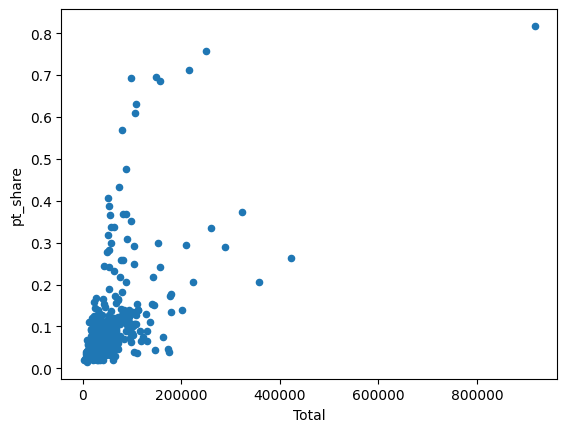

In [30]:
od_share.plot(kind='scatter', x = 'Total', y ='pt_share')

In [31]:
od_share[od_share['destination_name'].isin(['Liverpool', 'Manchester', 'Sheffield', 'Leeds', 'York', 'Doncaster', 'Kingston upon Hull, City of', 'Kirklees', 'Bradford', 'Wakefield', 'Barnsley', 'Rotherham', 'Stockport', 'Westminster,City of London', 'Birmingham'])].to_csv('data/od_share_northern.csv', index=False)
od_share.to_csv('data/od_share_all.csv', index=False)